In [68]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
from datetime import datetime as dt
import torch

In [69]:
data=pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

In [84]:
#Extracting cases for India

india=data.loc[data['Country/Region']=='Nepal']
india=india.drop(['Province/State','Country/Region','Lat','Long'],axis=1)
india=india.transpose()
india.reset_index(level=0, inplace=True)
india.columns=['Date','Cases']
india=india.loc[india.Cases>0]

#Converting Cumulative Counts to Daily Cases

arr=np.zeros(india.shape[0])
arr[0]=india.iloc[0,1]
for i in range(1,india.shape[0]):
  arr[i]=int(india.iloc[i,1]-india.iloc[i-1,1])

india['Cases']=arr

#Converting Dates to Date time variable for ease of plotting
for i in range(india.shape[0]):
  india.Date.iloc[i]=dt.strptime(india.Date.iloc[i],"%m/%d/%y")

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [85]:
india.iloc[:,1]=india.iloc[:,1]/10000
india

,Date,Cases
3,2020-01-25 00:00:00,0.0001
4,2020-01-26 00:00:00,0.0000
5,2020-01-27 00:00:00,0.0000
6,2020-01-28 00:00:00,0.0000
7,2020-01-29 00:00:00,0.0000
...,...,...
815,2022-04-16 00:00:00,0.0006
816,2022-04-17 00:00:00,0.0011
817,2022-04-18 00:00:00,0.0009
818,2022-04-19 00:00:00,0.0010


In [86]:
#Function to create lag

def lag(arr,n):
    s=len(arr)
    for i in range(1,s-n+1):
        arr[s-i]=arr[s-i-n]
        
    for i in range(n):
        arr[i]=0
    
    return arr

In [87]:
#Adding Last 5 days cases.

c=india.Cases.to_numpy().copy()
l=lag(c,1)
india['Cases_1']=l

c=india.Cases.to_numpy().copy()
l=lag(c,2)
india['Cases_2']=l

c=india.Cases.to_numpy().copy()
l=lag(c,3)
india['Cases_3']=l

c=india.Cases.to_numpy().copy()
l=lag(c,4)
india['Cases_4']=l

c=india.Cases.to_numpy().copy()
l=lag(c,5)
india['Cases_5']=l

In [88]:
india

,Date,Cases,Cases_1,Cases_2,Cases_3,Cases_4,Cases_5
3,2020-01-25 00:00:00,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000
4,2020-01-26 00:00:00,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000
5,2020-01-27 00:00:00,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000
6,2020-01-28 00:00:00,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000
7,2020-01-29 00:00:00,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000
...,...,...,...,...,...,...,...
815,2022-04-16 00:00:00,0.0006,0.0014,0.0003,0.0015,0.0023,0.0022
816,2022-04-17 00:00:00,0.0011,0.0006,0.0014,0.0003,0.0015,0.0023
817,2022-04-18 00:00:00,0.0009,0.0011,0.0006,0.0014,0.0003,0.0015
818,2022-04-19 00:00:00,0.0010,0.0009,0.0011,0.0006,0.0014,0.0003


In [89]:
#Defining the structure of the neural network. 
H=2 #Number of nodes in the hidden layer
D_in = 5 #Number of input nodes i.e. 5 input features
D_out = 1 #Number of Output

model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),  
    torch.nn.Linear(H, D_out)
)

# In Sample Error

In [90]:
x = torch.from_numpy(india[['Cases_1','Cases_2', 'Cases_3', 'Cases_4', 'Cases_5', ]].values)
y = torch.from_numpy(india[['Cases']].values)
x = x.float()
y = y.float()
#x=torch.nn.functional.normalize(x)
#y=torch.nn.functional.normalize(y)

In [98]:
#Training on whole of the data
#Using Mean Absolute Error Loss Function

loss_fn = torch.nn.MSELoss(reduction='sum') 

learning_rate = 1e-4
for t in range(100000):
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    if t % 10000 == 0:
      print(t, loss.item())
    model.zero_grad()
    loss.backward()
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

0 2.1075844764709473
10000 1.6756527423858643
20000 1.671614170074463
30000 1.671035885810852
40000 1.6705636978149414
50000 1.6701252460479736
60000 1.6697275638580322
70000 1.6693589687347412
80000 1.669026255607605
90000 1.6687122583389282


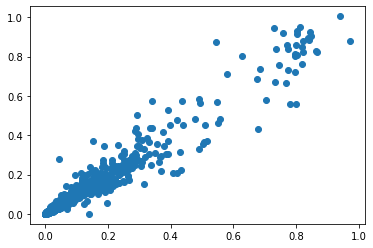

In [99]:
#Calculating the predicted value
y_pred=model(x)

a = y_pred.detach().numpy()

plt.scatter(a[:,0], y[:,0])

Error is -0.002314039011253044


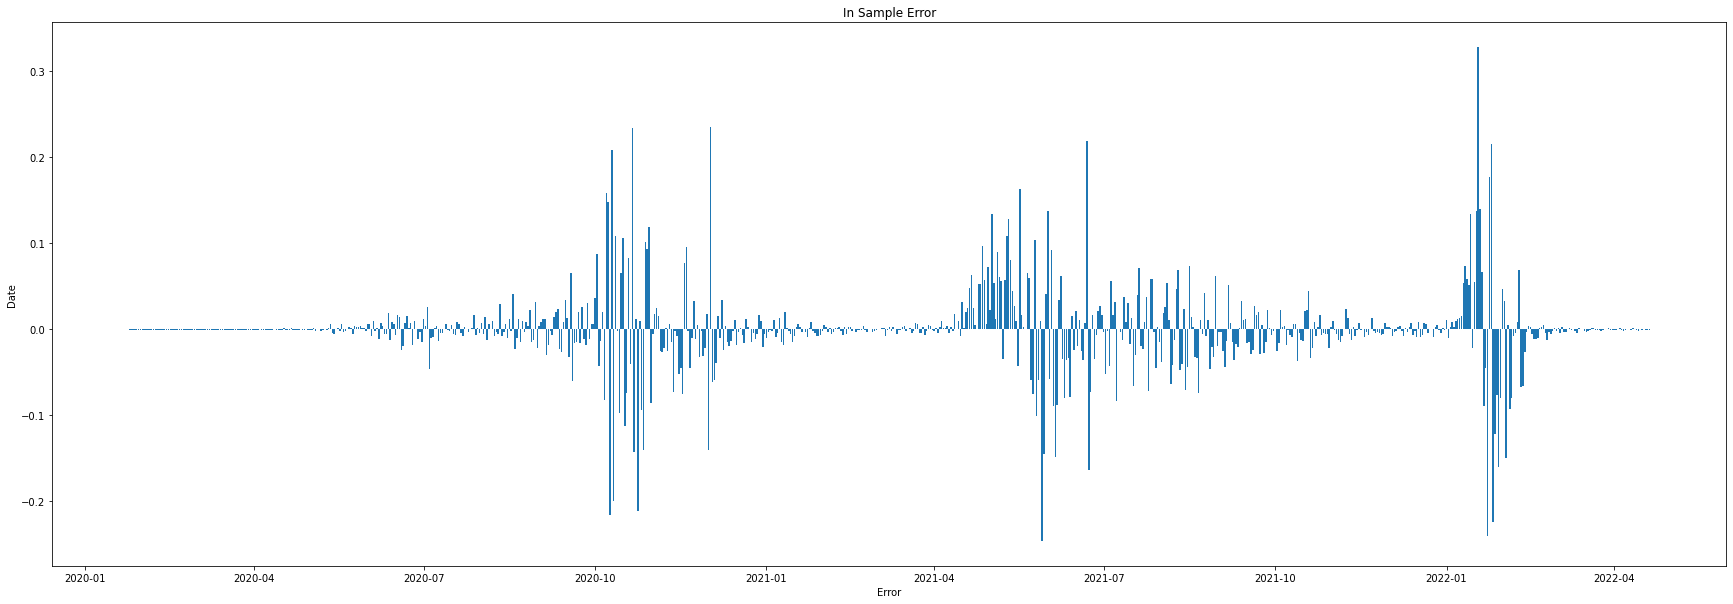

In [100]:
fig=plt.figure(figsize=(30,10))
plt.bar(india.Date,(y-y_pred).detach().numpy().reshape(-1))
plt.title("In Sample Error")
plt.xlabel("Error")
plt.ylabel("Date")
err=np.mean((y-y_pred).detach().numpy().reshape(-1))
print("Error is "+str(err*100))

In [94]:
y_train=india[['Cases']].iloc[0:int(len(y)/2)]
x_train=india.drop(['Date', 'Cases'], axis=1).iloc[0:int(len(y)/2),:]
y_test=india[['Cases']].iloc[int(len(y)/2):]
x_test=india.drop(['Date', 'Cases'], axis=1).iloc[int(len(y)/2):,:]

y_train=torch.from_numpy(y_train.values)
x_train=torch.from_numpy(x_train.values)
y_test=torch.from_numpy(y_test.values)
x_test=torch.from_numpy(x_test.values)

x_test=x_test.float()
x_train=x_train.float()
y_train=y_train.float()
y_test=y_test.float()
#y_train=torch.nn.functional.normalize(y_train)
#y_test=torch.nn.functional.normalize(y_test)
#x_test=torch.nn.functional.normalize(x_test)
#x_train=torch.nn.functional.normalize(x_train)

In [95]:
#Training on first half of the data
#Using Mean Absolute Error Loss Function

loss_fn = torch.nn.MSELoss(reduction='sum') 

learning_rate = 1e-4
for t in range(100000):
    y_pred = model(x_train)
    loss = loss_fn(y_pred, y_train)
    if t % 10000 == 0:
      print(t, loss.item())
    model.zero_grad()
    loss.backward()
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

0 0.6088950634002686
10000 0.5071234703063965
20000 0.4956214129924774
30000 0.49326807260513306
40000 0.4926978051662445
50000 0.4925464987754822
60000 0.4925033152103424
70000 0.49249032139778137
80000 0.4924861788749695
90000 0.4924847483634949


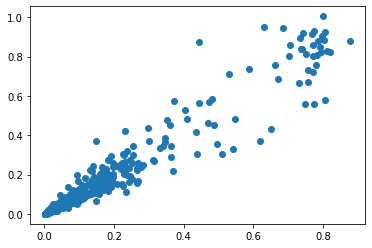

In [96]:
#Calculating the predicted value
y_pred=model(x_test)

a = y_pred.detach().numpy()

plt.scatter(a[:,0], y_test[:,0])

Error is 0.6250513251870871


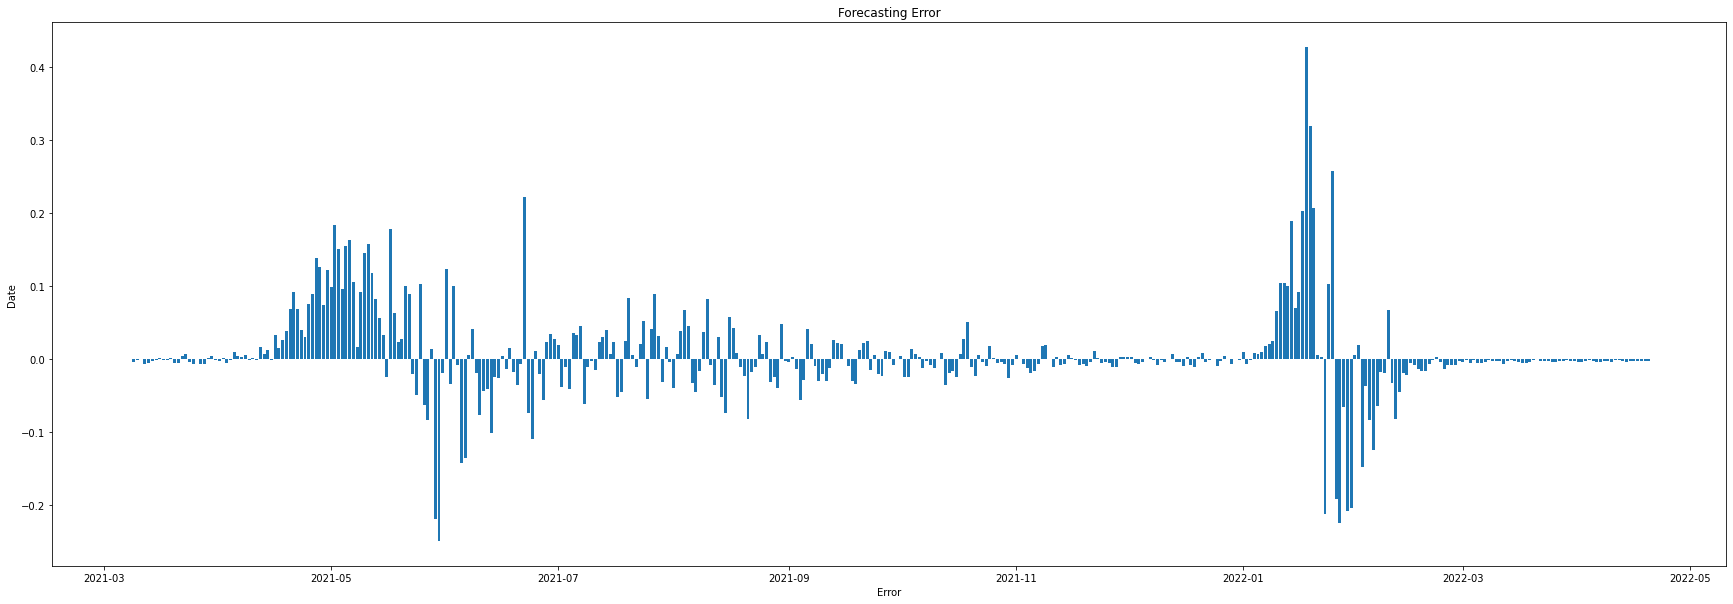

In [97]:
fig=plt.figure(figsize=(30,10))
plt.bar(india.Date.iloc[int(len(y)/2):],(y_test-y_pred).detach().numpy().reshape(-1))
plt.title("Forecasting Error")
plt.xlabel("Error")
plt.ylabel("Date")
acc=np.mean((y_test-y_pred).detach().numpy().reshape(-1))
print("Error is "+str(acc*100))